In [1]:
%cd ..
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [2]:
import scanpy as sc

Retrieve true file path in drive through link:

In [ ]:
# %pip install winshell

In [ ]:
# import winshell
# import os

# shortcut_path = r"H:/Il mio Drive/dati_per_enrico.lnk"
# real_path = winshell.shortcut(shortcut_path).path

# print(f"Real path: {real_path}")

# # Now test it
# if os.path.exists(real_path):
#     print("Resolved path is accessible")
# else:
#     print("Resolved path is not available")

In [4]:
!dir

data			 Notebooks	 requirements.txt  test_script.py
full_module_test_old.py  pyproject.toml  tangramlit	   train_config.yaml
myvenv			 README.md	 tb_logs	   uv.lock


# Data loading
Data used here underwent several preprocessing steps including:
* normalization and log-transfrom of counts
* cell selection on scRNA data
* label harmonization between modalitites
* identification of HVGs
* sparsity annotation
* computation of UMAP embeddings and expression graphs
* computation of neighbors graph for ST data.

In [6]:
## Load pre-processed datasets
path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data"
adata_sc = sc.read_h5ad(path + "/test_sc_crop.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 400 × 249
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'n_cells'
    uns: 'overlap_genes', 'training_genes'
    layers: 'logcounts'

In [7]:
adata_st = sc.read_h5ad(path + "/slice200_norm_with_spatial.h5ad")
adata_st

AnnData object with n_obs × n_vars = 2155 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'is_sequential', 'is_combinatorial'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

# Loss coefficients: $\lambda$s
Depending on the mode (cells or constrained) the Tangram loss function has either up to 4 or up to 6 regularization coefficients. These coefficients scale (are multiplied to) each single term of the Loss and are quite necessary, since loss terms are defined heuristically and are not in the same order of magnitude by default. In fact quite the opposite is true: cosine similarity terms map into [-1, 1] by definition (and their mean as well), KL divergence is non-negative but with no upper bound, the entropy regularizer has no bound as well and filtering related terms are in the order of magnitude equal the number of target cells (i.e., number of spots).

For this reason, an initial set of coefficients that ensures all terms live approximately on the same scale is required. To do so, one can first run a naive unitary set and, based on visual inspection, retrieve the orders of magnitude and adjust accordingly. Alternatively, the values could be automatically set to match the order of magnitude of the terms in the first training step (as soon as the initial value of each term is available) and auto-adjust.

Subsequently, one can either turn off loss terms at will by assigning the corresponding coefficient a value of 0 or create a custom set based off of loss behaviour and mapping results.

## Baseline model
A baseline model, with all $\lambda$s set to 1, is trained for a few epochs to evaluate the order of magnitude of each loss term for the different modes available:

In [6]:
ad_map_baseline, mapper_baseline, data_baseline = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.1,
        num_epochs=200,
        lambda_d=1,
        lambda_g1=1,
        lambda_g2=1,
        lambda_r=1,
        lambda_l1=1,
        lambda_l2=1,
        random_state=42,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])

Validation 0: {'Validation Score': 0.5169236660003662, 'Sparsity-weighted Score': 0.0025671806652098894, 'AUC': 0.6502220630645752, 'Entropy': 0.9348827004432678}


Trainig:   0%|                                                                                 | 0/200 [00:00<?, ?it/s]


Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   0%|▎                                                                      | 1/200 [00:29<1:36:26, 29.08s/it]

Epoch 0: {'loss': 297163904.0, 'main_loss': 0.5169236660003662, 'vg_reg': 0.512692391872406, 'kl_reg': 1.1752592399716377e-05, 'entropy_reg': -554207.9375, 'l1_term': 131630208.0, 'l2_term': 164979488.0}


Trainig:  50%|███████████████████████████████████▊                                   | 101/200 [12:32<13:03,  7.91s/it]

Epoch 100: {'loss': 1865733.875, 'main_loss': 0.5172168016433716, 'vg_reg': 0.5127074718475342, 'kl_reg': -8.638016879558563e-08, 'entropy_reg': -592805.375, 'l1_term': 1252809.5, 'l2_term': 20120.046875}


Trainig: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [24:57<00:00,  7.49s/it]


Validation 199: {'Validation Score': 0.517216145992279, 'Sparsity-weighted Score': 0.002567883115261793, 'AUC': 0.6504871845245361, 'Entropy': 1.0}


Initial value of total_loss 297163904.0
Initial value of main_loss 0.5169236660003662
Initial value of vg_reg 0.512692391872406
Initial value of kl_reg 1.1752592399716377e-05
Initial value of entropy_reg -554207.9375
Initial value of l1_term 131630208.0
Initial value of l2_term 164979488.0


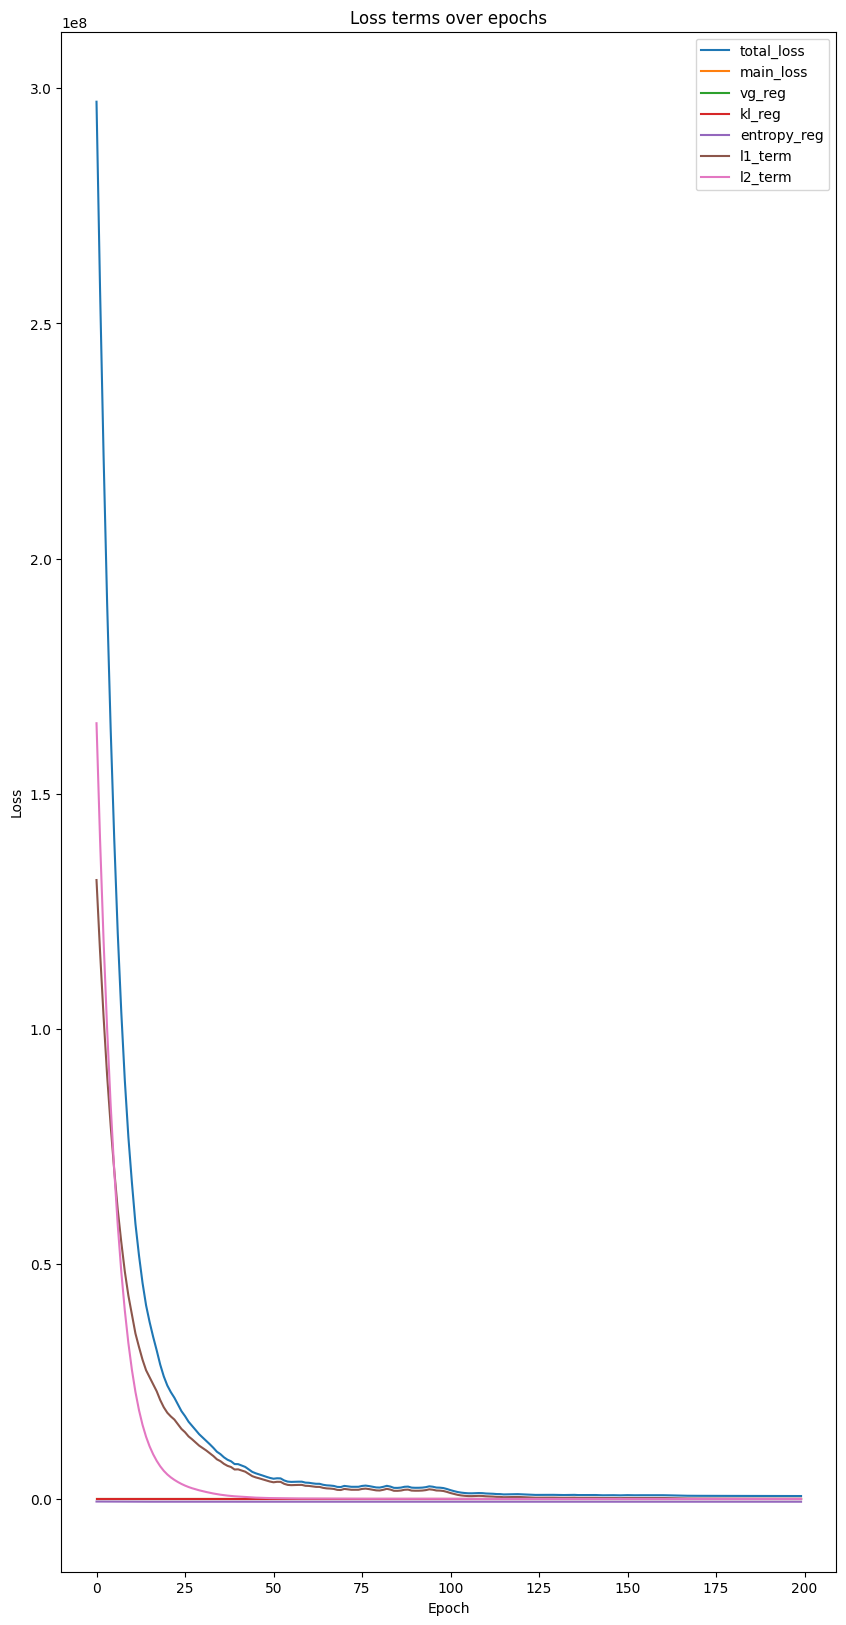

In [7]:
# Plot loss terms
for term in ad_map_baseline[0].uns['training_history'].keys():
    value = ad_map_baseline[0].uns['training_history'][term][0]
    print("Initial value of", term, value)
    
tgl.plot_training_history(adata_map=ad_map_baseline, hyperpams=mapper_baseline.hparams,
                   log_scale=False, lambda_scale=False)

As we can see initial values are all over the place in terms of scale. $\mathcal{l}-norm$ regularizers reach huge orders of magnitudes, followed by the entropy regularizer; all these terms are summing the whole mapping matrix $M$ into a scalar. The main terms are thus overtaken completely in the gradient signal.

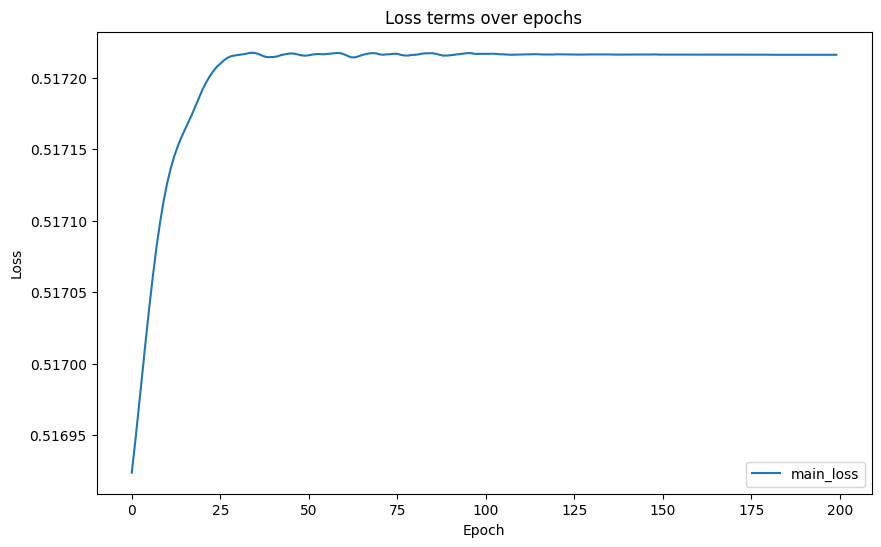

In [8]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map_baseline, loss_key="main_loss", lambda_scale=False)

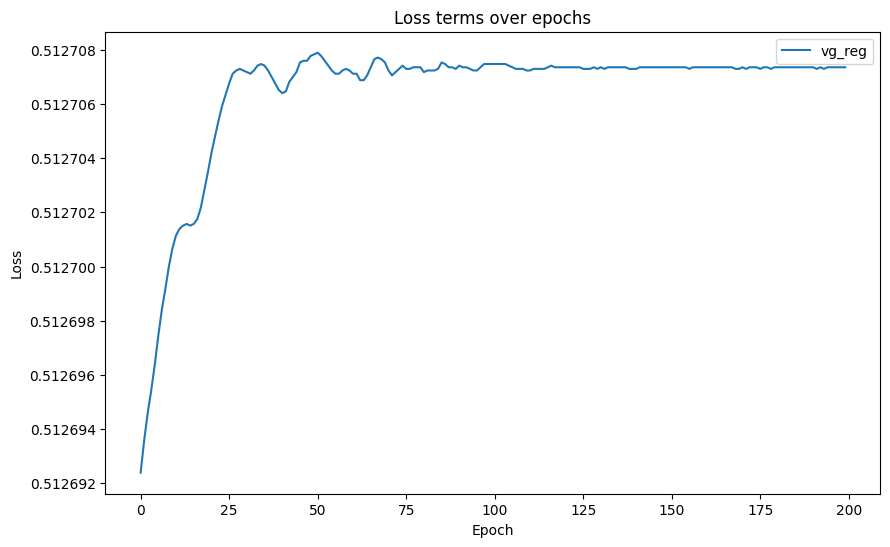

In [10]:
# Plot voxels/genes term
tgl.plot_loss_term(adata_map=ad_map_baseline, loss_key="vg_reg", lambda_scale=False)

We can also observe poor convergence of the similarity terms towards a value very close to the initial one, denoting no actual improvement.

## Baseline model (no L-norm)
The same experimetn repeated with $L-norm$ regularizers (most dominating terms) completely turned off:

In [11]:
ad_map_baseline, mapper_baseline, data_baseline = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.1,
        num_epochs=200,
        lambda_d=1,
        lambda_g1=1,
        lambda_g2=1,
        lambda_r=1,
        lambda_l1=0,
        lambda_l2=0,
        random_state=42,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])

Validation 0: {'Validation Score': 0.5169236660003662, 'Sparsity-weighted Score': 0.0025671806652098894, 'AUC': 0.6502220630645752, 'Entropy': 0.9348827004432678}


Trainig:   0%|                                                                                 | 0/200 [00:00<?, ?it/s]


Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   0%|▎                                                                        | 1/200 [00:12<41:09, 12.41s/it]

Epoch 0: {'loss': 554206.9375, 'main_loss': 0.5169236660003662, 'vg_reg': 0.512692391872406, 'kl_reg': 1.1752592399716377e-05, 'entropy_reg': -554207.9375}


Trainig:  50%|███████████████████████████████████▊                                   | 101/200 [14:13<14:08,  8.57s/it]

Epoch 100: {'loss': 4570.6201171875, 'main_loss': 0.4301843047142029, 'vg_reg': 0.4993177652359009, 'kl_reg': 0.014401246793568134, 'entropy_reg': -4571.53515625}


Trainig: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [28:05<00:00,  8.43s/it]


Validation 199: {'Validation Score': 0.4290560185909271, 'Sparsity-weighted Score': 0.0022508460097014904, 'AUC': 0.5726152658462524, 'Entropy': 0.000705754675436765}


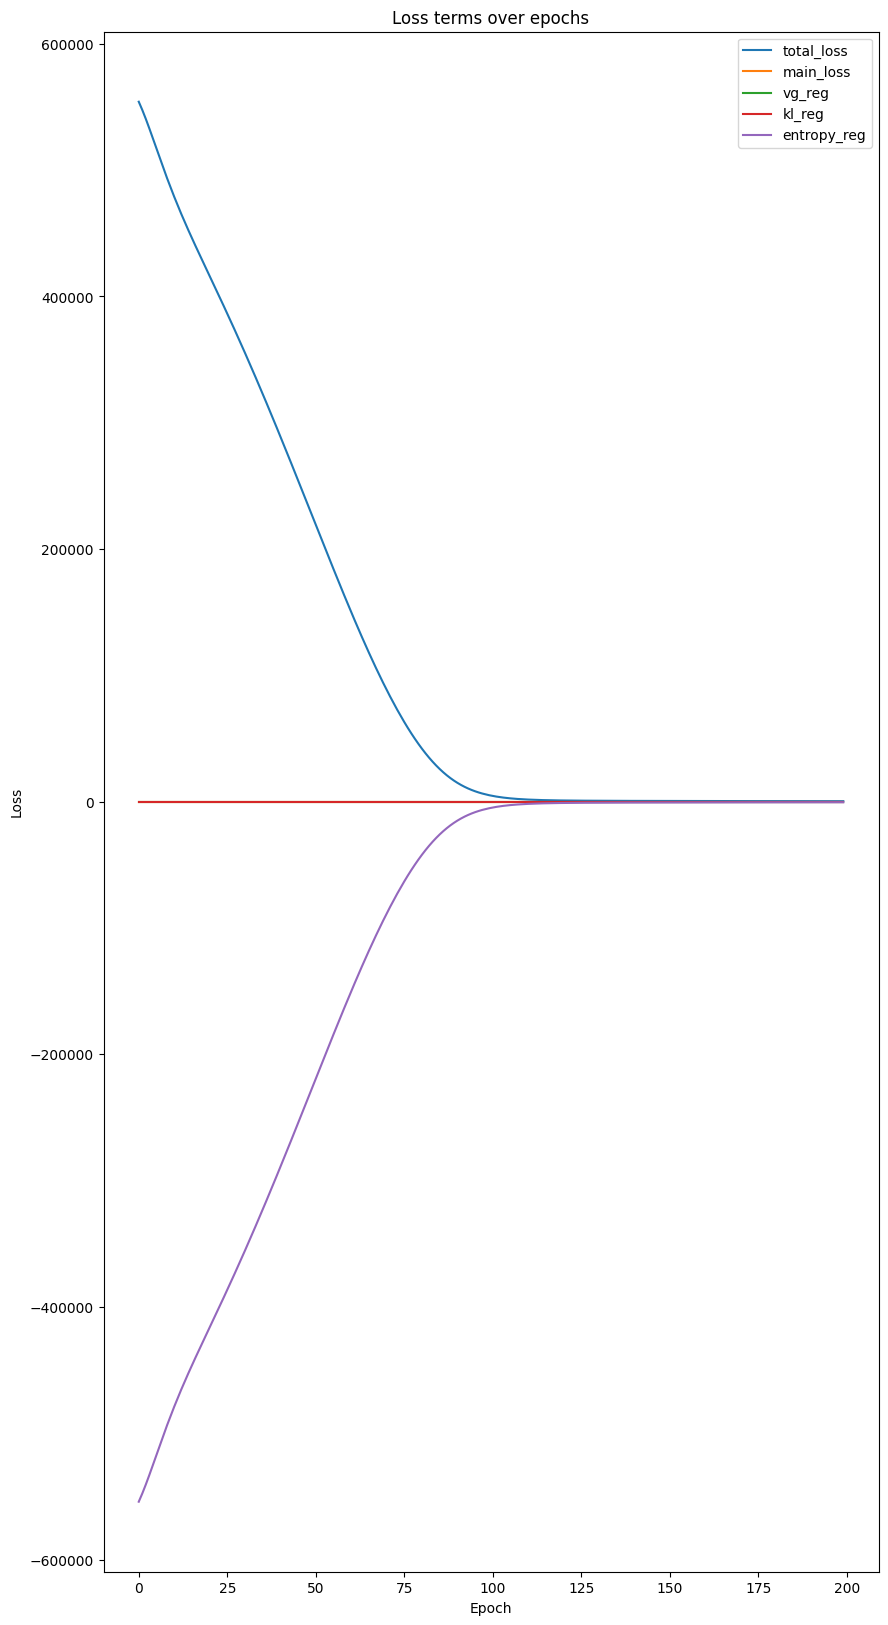

In [14]:
# Plot all terms
tgl.plot_training_history(adata_map=ad_map_baseline, hyperpams=mapper_baseline.hparams,
                   log_scale=False, lambda_scale=False)

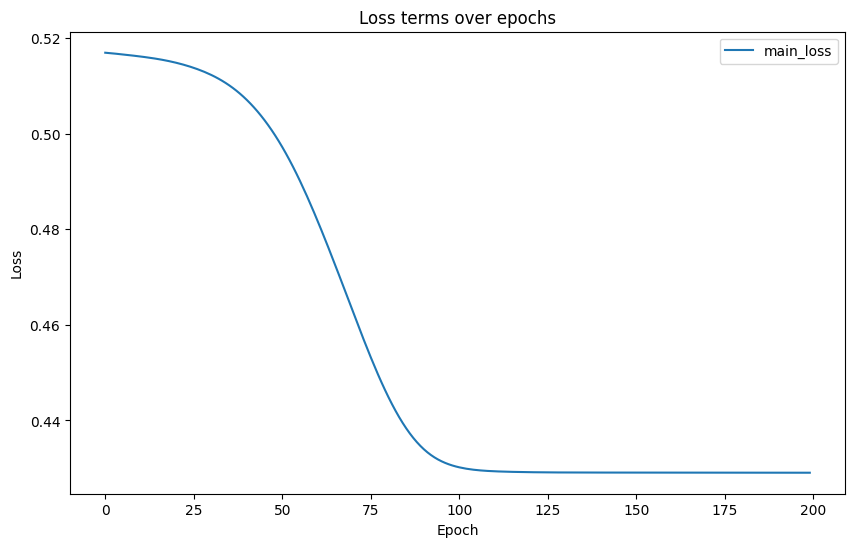

In [15]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map_baseline, loss_key="main_loss", lambda_scale=False)

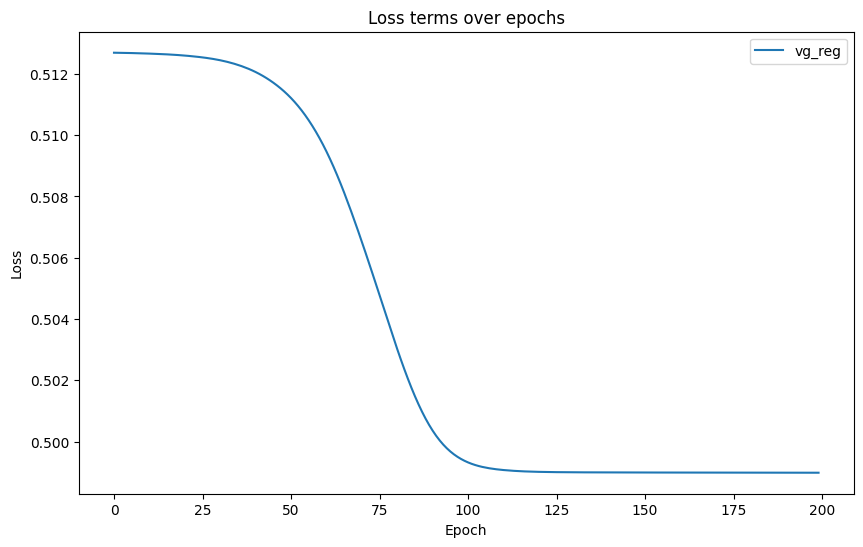

In [16]:
# Plot voxels/genes term
tgl.plot_loss_term(adata_map=ad_map_baseline, loss_key="vg_reg", lambda_scale=False)

Allowingh the entropy regularizer to dominate yields a convergence towards an alignment worse than the original.

## Baseline model (no Regularization)
Finally a model with only the main loss and KL divergence acting is trained:

In [17]:
ad_map_baseline, mapper_baseline, data_baseline = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.1,
        num_epochs=200,
        lambda_d=1,
        lambda_g1=1,
        lambda_g2=0,
        lambda_r=0,
        lambda_l1=0,
        lambda_l2=0,
        random_state=42,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])

Validation 0: {'Validation Score': 0.5169236660003662, 'Sparsity-weighted Score': 0.0025671806652098894, 'AUC': 0.6502220630645752, 'Entropy': 0.9348827004432678}


Trainig:   0%|                                                                                 | 0/200 [00:00<?, ?it/s]


Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   0%|▎                                                                      | 1/200 [00:32<1:47:48, 32.50s/it]

Epoch 0: {'loss': -0.5169119238853455, 'main_loss': 0.5169236660003662, 'kl_reg': 1.1752592399716377e-05}


Trainig:  50%|███████████████████████████████████▊                                   | 101/200 [15:04<14:35,  8.85s/it]

Epoch 100: {'loss': -0.8915885090827942, 'main_loss': 0.893580973148346, 'kl_reg': 0.0019924368243664503}


Trainig: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [28:37<00:00,  8.59s/it]


Validation 199: {'Validation Score': 0.9048123955726624, 'Sparsity-weighted Score': 0.003579838201403618, 'AUC': 0.8585219979286194, 'Entropy': 0.09988822788000107}


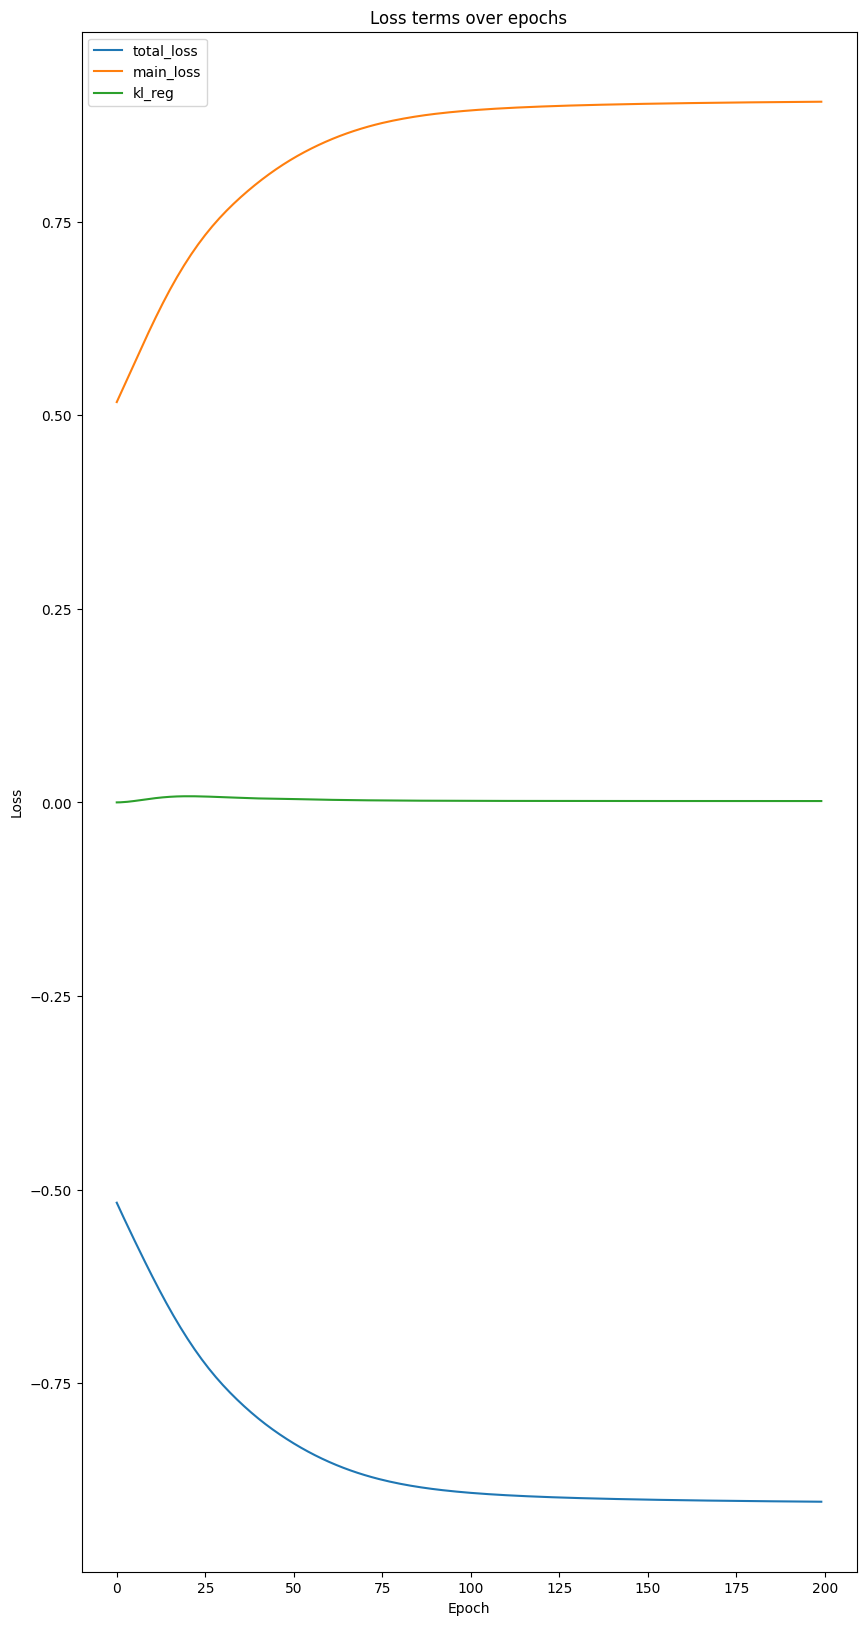

In [18]:
# Plot all terms
tgl.plot_training_history(adata_map=ad_map_baseline, hyperpams=mapper_baseline.hparams,
                   log_scale=False, lambda_scale=False)

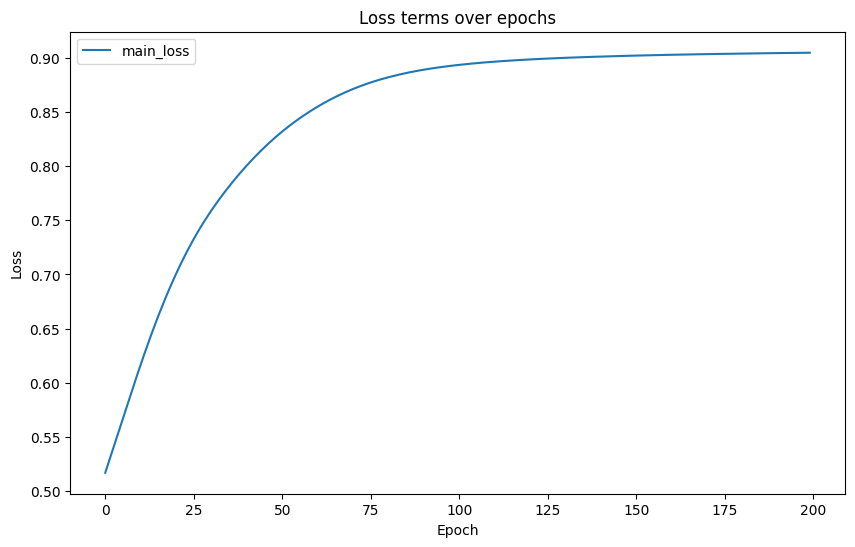

In [19]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map_baseline, loss_key="main_loss", lambda_scale=False)

This last experiment shows how the main loss, paired with the KL divergence term, can achieve a very smooth, stable and successful alignment, without any regularization.

## Automatic coefficients
In this section we develop a function that automatically computes a suitable set of regularization hyperparameters, based on the scale of the existing input arguents to the mapping function.

* We know that all cosine similarity terms are, by definition, bounded in the $[-1, 1]$ interval and can possibly be shifted into $[0,2]$ by settig loss terms as $1-cossim()$. This would also turn the problem into a direct minimization instead of a negative maximization. Note that this is true because the loss terms are obtained as the average similarity over the rows/columns of the spatial matrices, alternatively one could use the sum, which would make the magnitude dependent on the input data size.

* The KL term has, by definition, a lower bound of 0 that is, ideally, approached during the optimization. The initial value depends on both the prior distribution $d$ (**uniform**) and the starting estimate $m$, which depends on the IC for the matrix $M$. One can try to analytically extract an upper bound based on the initial estimated distribution.

* The entropy regularizer term is theoretically upper bounded by a uniform distribution over the values of $M$.

* The target count term initial value depends on the absolute number of cells in both datasets and the initial conditions of the filter. i.e. the expected value of the sum of its entries.

* The filter regularizer initial value can be described by a transformation of the expected value of the sum of the filter terms.

* Refinement term have scales depending mainly on the weighting matrices' magnitudes, which om their part depend mainly on the counts and neighbors graph.

The problem is then to determine what is the optimal scale to move everything in: one could move all terms into the unitary ($10^0$) magnitude or a larger/smaller one. The core idea is that the order of magnitude affects losses absolute values and consequenlty all the gradient values. Ultimately, this affects the optimization only for basic algorithms that to not include an adaptive learning rate (like standard SDG), where the scale factor acts on the learning rate itself. Optimizers with an adaptive learning eate, like Adam, are scale invariant so this problem does not persist.

In this final context, the rule by which all terms are compared to the unitary scale of the main loss seems to be the most appropriate. To speed up training, a larger learning rate will serve good enough, as shown later.

## Optuna Search
In the Refinements paper, loss terms' coefficients, which are in fact hyperparameters of the mapper, are tuned with an **Optuna** grid search, with the objective of maximizing several multiple-run consistency metrics.

The considerations made above could be used to set up a proper fine grid for each term, skipping the coarse search step.

# Model Analysis
Now that a reasonable set of hyperparamters is identified, we proceed by fully trainig the Vanilla model.

In [21]:
ad_map_vanilla, mapper_vanilla, data_vanilla = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.1,
        num_epochs=100,
        lambda_d=1e2,
        lambda_g1=1,
        lambda_g2=1,
        lambda_r=1e-6,
        lambda_l1=2e-9,
        lambda_l2=2e-9,
        random_state=42,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])

Validation 0: {'Validation Score': 0.5169236660003662, 'Sparsity-weighted Score': 0.0025671806652098894, 'AUC': 0.6502220630645752, 'Entropy': 0.9348827004432678}


Trainig:   0%|                                                                                 | 0/100 [00:00<?, ?it/s]


Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   1%|▋                                                                        | 1/100 [00:16<26:31, 16.08s/it]

Epoch 0: {'loss': 0.11898645758628845, 'main_loss': 0.5169236660003662, 'vg_reg': 0.512692391872406, 'kl_reg': 0.0011752592399716377, 'entropy_reg': -0.5542079210281372, 'l1_term': 0.2632603943347931, 'l2_term': 0.329958975315094}


Trainig: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [13:30<00:00,  8.10s/it]


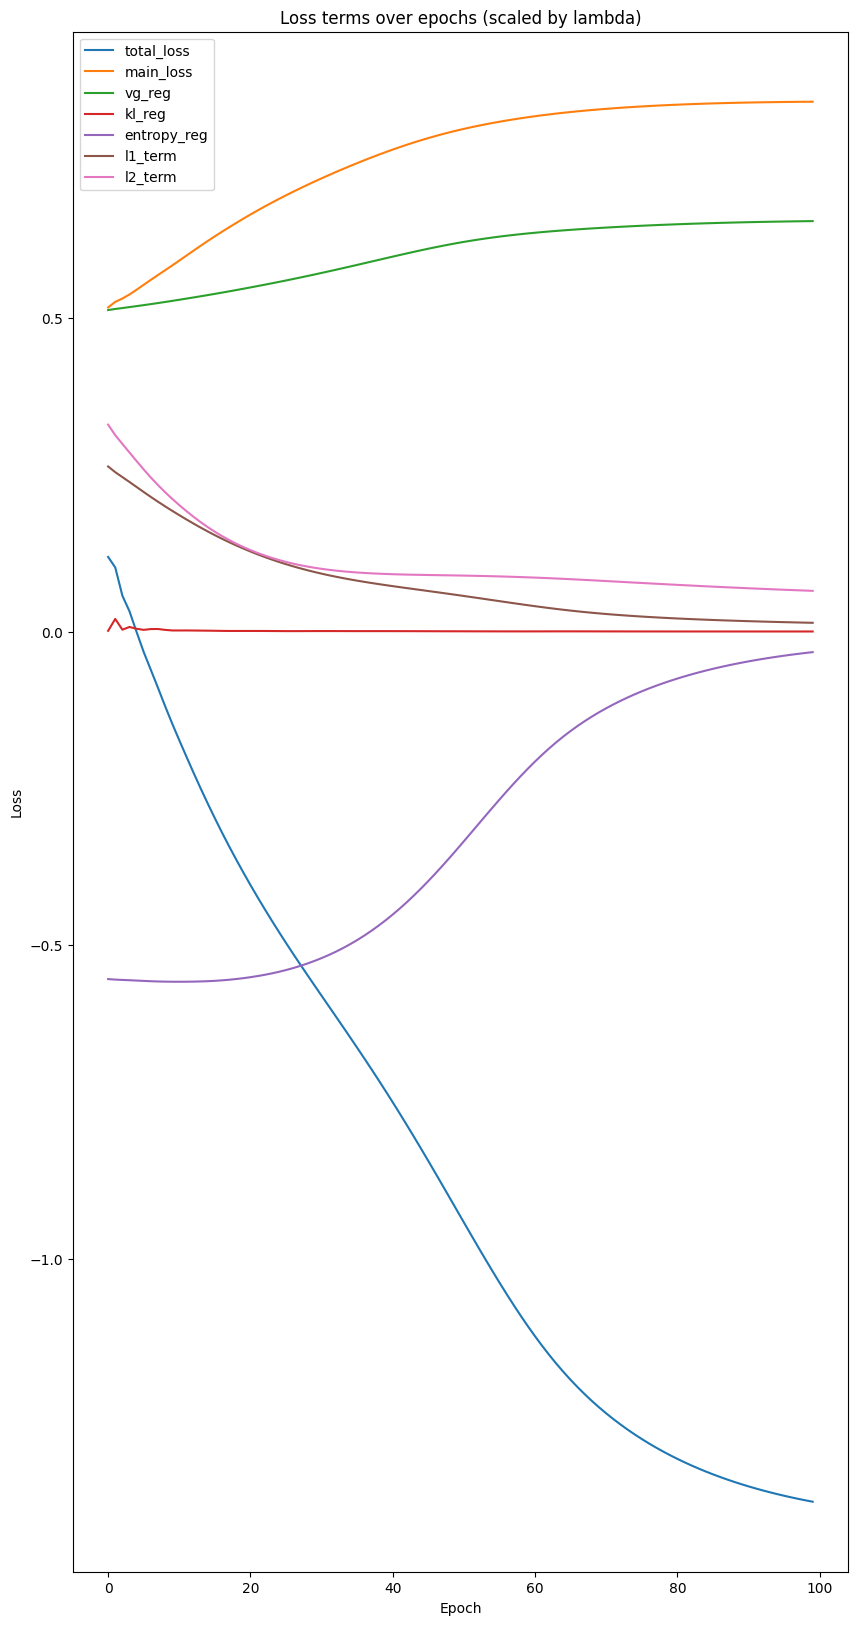

In [22]:
tgl.plot_training_history(adata_map=ad_map_vanilla, hyperpams=mapper_vanilla.hparams,
                   log_scale=False, lambda_scale=True)

## Loss Landscape
One of the most prominent features of Tangram as a non-convex optimization problem is that it does not implement minibatching, as it learns the whole projection matrix at each training step, using all datapoints. 

This implies that the gradient is computed on the whole dataset with no effective stochastic component, translating into extremely smooth loss trajectories.

The smoothness of the loss landscape is not reliant on this fact per se, but having a deterministic gradient signal allows to asses this quality much more directly. In fact, only a few terms exhibit a rougher trajectory.

Moreover, the loss function has terms that live on distinct parameter spaces, namely:
* All filterm terms depend only on the filter entries $f$
* The entropy and $\mathcal{l}-norm$ regularizer terms and depend only on the unfiltered (softmax) projection matrix $M$;
*  All the other terms depend on the joint parameters space of the filtered matrix $M$ (if filtering is applied), namely the original cosine similarities, their refined weightings and the KL divergence.

When filtering is not implemented, the parameter space contains only the matrix $M$.


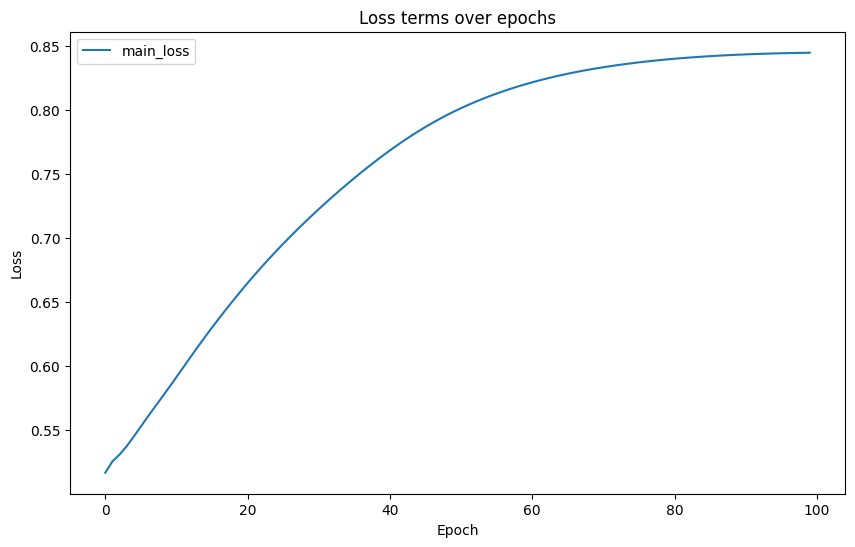

In [23]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map_vanilla, loss_key="main_loss", lambda_scale=False)

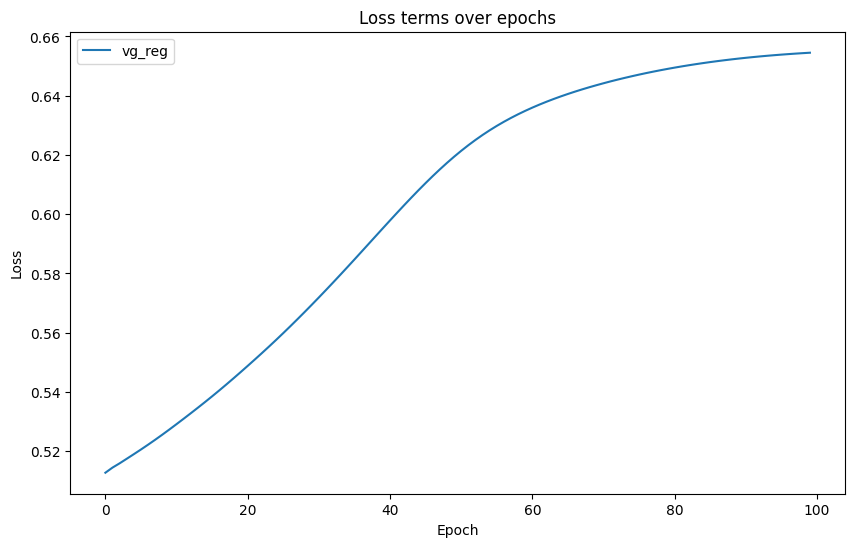

In [24]:
# Plot voxels/genes term
tgl.plot_loss_term(adata_map=ad_map_vanilla, loss_key="vg_reg", lambda_scale=False)

## Optimizer
With SGD no improvement in the loss is seen even after 200 epochs (completely stagnating gradient).

To further investigate it might be worth trying other initial conditions (perhaps base them on the final values that the M matrix with no softmax or filtering converges to and if they're coherent with the initial values).
Another aspect is the optimizer: ADAM works well, so first one can introduce momentum and see if it help escaping the flat zone quicker and secondly introduce adaptive learning rates and study theur behavior (how do they move in the loss landscape).

Anyhow, loss terms seem to have a pretty smooth trajectory with quite fast convergence when using ADAM.

The main reason why SGD might not work is that Tangram does not implement minibatches, as explained above. This implies that the gradient is computed on the whole dataset with no effective stochastic component that usually ensures the optimizer to explore more rapidly the loss landscape. Adding momentum could help accelerate but an adaptive learning rate is clearly the best approach.

Another reason for adaptive learning rates is the scale problem mentioned above: with this approach the magnitued of the gradient is scaled automatically preventing large terms to overtake completely the gradient descent. The issue of scales persists only at the beginning, when Adam has not yet adjusted the scales.

The presence of a joint parameters space (section above) also argues in favor of a (single) adaptive optimizer as the best choice, as it can separate the learning process in the parameters sub-spaces.

## Learning rate
Given the smoothness of the loss landscape, it appears reasonable to adopt a larger learning rate to favour a faster convergence.

Smaller rates and additional scheduling are most suitable for complex and rough landscapes, where one can identify optimization phases with a different pace and a variable convergence.

Here, such behaviour is not observed, but a scheduler that reduces the rate on plateau is implemented anyway. One might train the model without it for comparison.

**Important note:** The learning rate scheduler, specifically one implementing a Reduction-on-Plateau schedule, is applied on the **total loss**, despite the main loss being the more reasonable choice. This way, smoother trajectories are achieved, whereas monitoring the main loss procudes sharper corners at the point where the plateau is approached.

**Convergence** is also superior with a scheduled *lr* on the total loss as it is at roughly $0.85$ average similarity, whereas applying it on the main term makes the score plateau at a much lower level, right below $0.62$. This suggests that other loss terms are still contributing later in the optimization to a propoer convergence, despite not being crucial at the beginning (aligns with the definition of regularizer).

In [17]:
ad_map_vanilla_2, mapper_vanilla_2, data_vanilla_2 = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.01,
        num_epochs=200,
        lambda_d=1e2,
        lambda_g1=1,
        lambda_g2=1,
        lambda_r=1e-6,
        lambda_l1=1e-9,
        lambda_l2=1e-9,
        random_state=42,
        )

in


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
Trainig:   0%|                                                                                 | 0/200 [00:00<?, ?it/s]

Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   0%|▎                                                                        | 1/200 [00:15<52:16, 15.76s/it]

Epoch 0: {'Total loss': -0.17762324213981628, 'Score': 0.5169236660003662, 'KL divergence': 1.1752592399716377e-05}


Trainig:  50%|███████████████████████████████████▊                                   | 101/200 [13:44<14:08,  8.57s/it]

Epoch 100: {'Total loss': -0.37677234411239624, 'Score': 0.6170180439949036, 'KL divergence': 1.5380792319774628e-06}


Trainig: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [27:53<00:00,  8.37s/it]


In [18]:
mapper_vanilla_2.hparams['learning_rate']

0.01

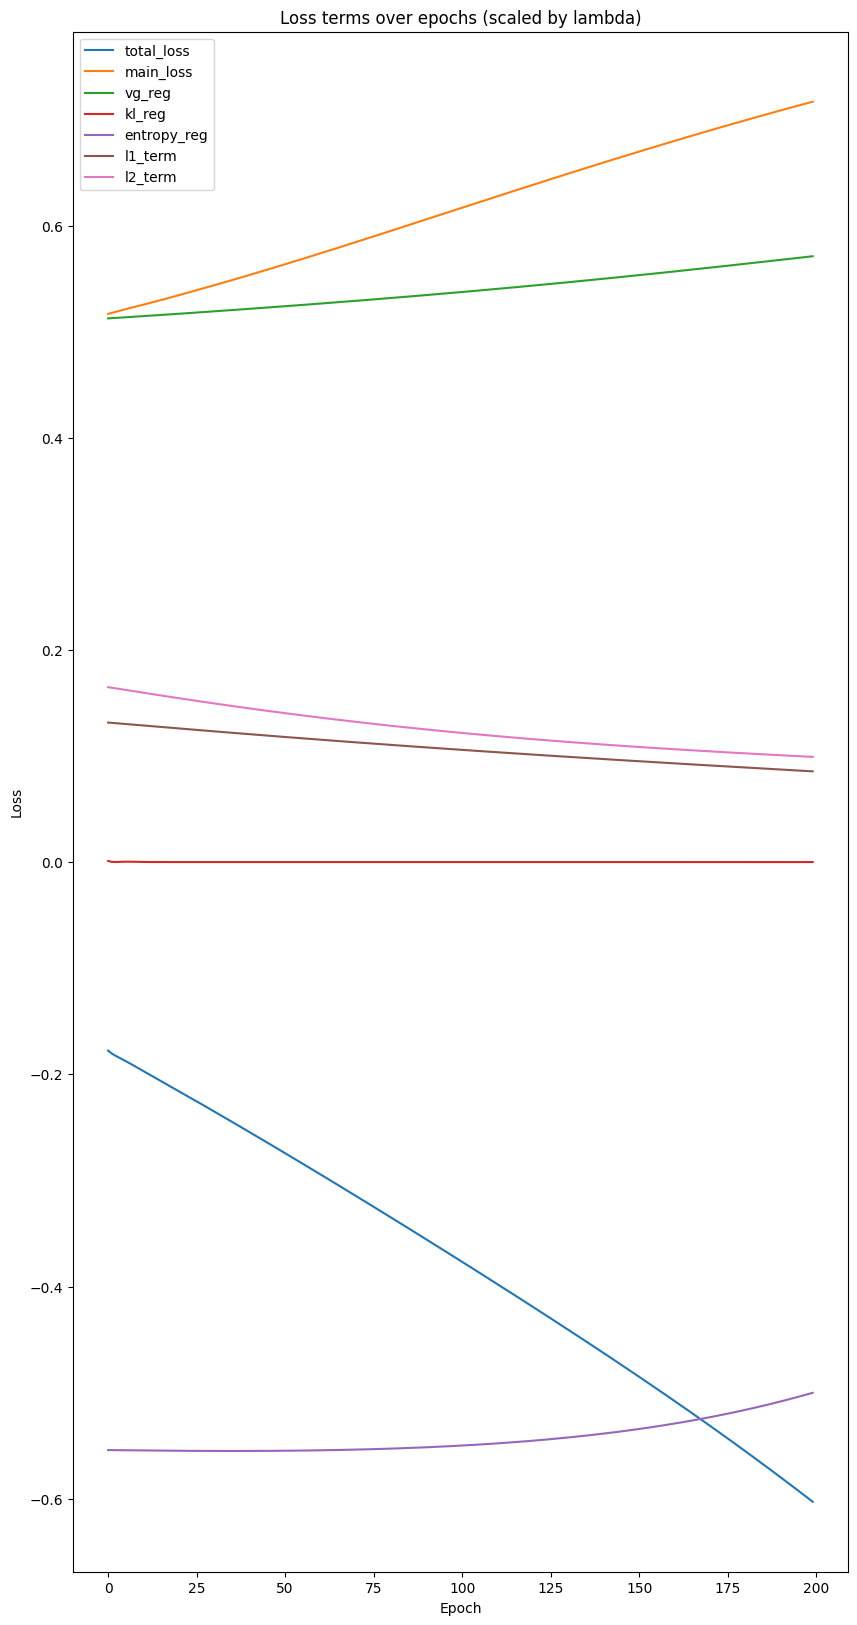

In [19]:
tgl.plot_training_history(adata_map=ad_map_vanilla_2, hyperpams=mapper_vanilla_2.hparams,
                   log_scale=False, lambda_scale=True)

A smaller learning rate makes convergence much slower, but does not help avoiding any landscape irregularity or local minima from what can be seen.

## KL Divergence
For single cell resolution spatial technologies, the simplest, but most reasonable, prior distribution of cell density over spots is the **Uniform** distribution. This comes directly from the fact that each spatial spot corresponds to a unique cell, thus alternatives like the *RNA count based density* (computed on the expression levels) does not make sense.

Despite the theoretical foundation, it appears that this term is of relative importance: its initial value, which one can derive analitically as the expected value of a sum of Normal variables subtraced to a uniform one, is already very small and does not increase any further.

This highlights the stability of the convergence and implies that this term might act as a "constraint" (forcing the distribution to not diverge from the prior) rather than being a strong training force.

In the case of pre-annotated spatial data, one could exploit such annotations to condition the prior.

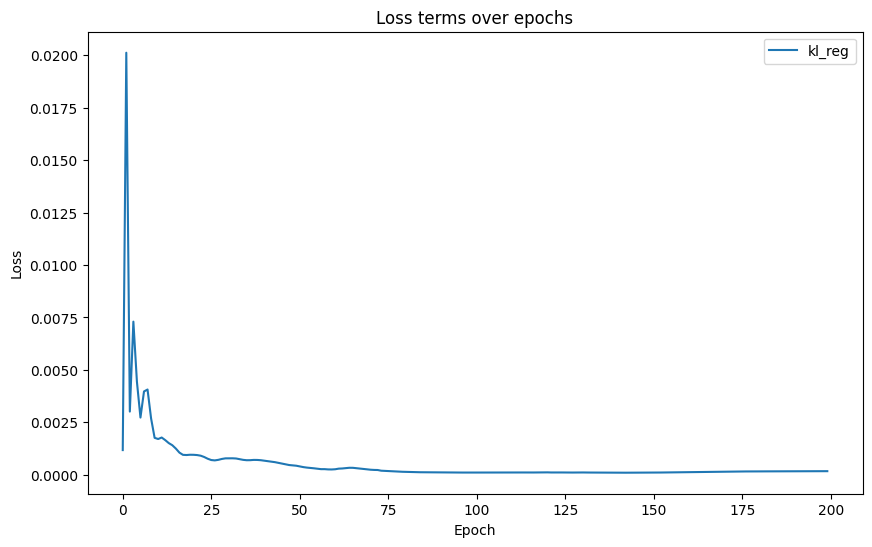

In [9]:
# Plot KL term
tgl.plot_loss_term(adata_map=ad_map_vanilla, loss_key="kl_reg", lambda_scale=False)

Lastly, it is worth noticing from the plot that this term starts around $1 \cdot 10^{-3}$ and immediately jumps to the order of magnitude above to $2 \cdot 10^{-2}$ (20 fold the initial value). A few more spikes are observed before the term finally settles very close to zero.

This behaviour, forces a more light weigthing of this term compared to what was initially indicated, e.g. assigning a $\lambda$ based on the firs value will cause instability in the total loss when the spiking arises. To mitigate this, $\lambda$ should be defined with respect to such spike (to move into the unitary order we set $\lambda=100$).

## Regularization
We now train the model with no regularization to asses the need of such terms:

In [29]:
ad_map_noreg, mapper_noreg, data_noreg = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.1,
        num_epochs=200,
        lambda_d=1e2,
        lambda_g1=1,
        lambda_g2=1,
        lambda_r=0,
        lambda_l1=0,
        lambda_l2=0,
        random_state=42,
        )

in


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
Trainig:   0%|                                                                                 | 0/200 [00:00<?, ?it/s]

Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   0%|▎                                                                      | 1/200 [00:24<1:21:33, 24.59s/it]

Epoch 0: {'Total loss': -1.0284408330917358, 'Score': 0.5169236660003662, 'KL divergence': 1.1752592399716377e-05}


Trainig:  50%|███████████████████████████████████▊                                   | 101/200 [13:24<13:30,  8.18s/it]

Epoch 100: {'Total loss': -1.5421379804611206, 'Score': 0.8757704496383667, 'KL divergence': 3.7320423871278763e-06}


Trainig: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [26:52<00:00,  8.06s/it]


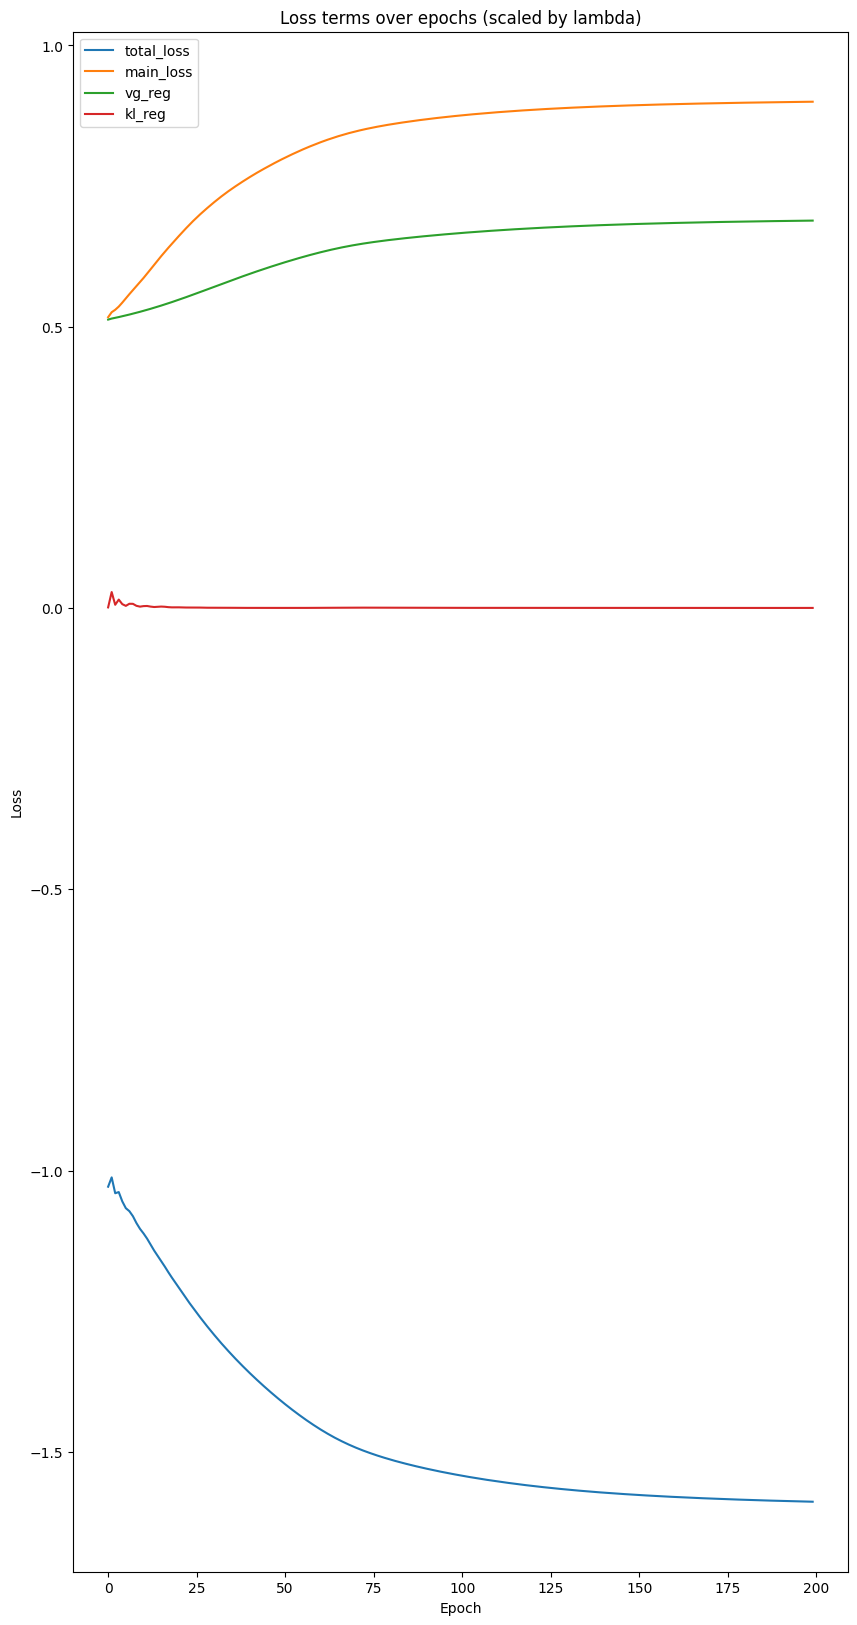

In [31]:
tgl.plot_training_history(adata_map=ad_map_noreg, hyperpams=mapper_noreg.hparams,
                   log_scale=False, lambda_scale=True)

Clearly, the convergence of the vanilla implementation is not heavily affected by the regularizers, achieving almost equivalent scores.

## Sparsity Analysis

In [27]:
ad_ge = tgl.project_sc_genes_onto_space(ad_map_vanilla, data_vanilla)

In [42]:
print(ad_ge.uns['training_genes'])
len(ad_ge.uns['training_genes'])

['trpc6', 'oprk1', 'spon1', 'tshz2', 'satb2', 'igfbp5', 'il1rapl2', 'chn2', 'dscaml1', 'rorb', 'bgn', 'rerg', 'l3mbtl4', 'pld5', 'lsp1', 'sp8', 'ntng2', 'fezf2', 'ceacam9', 'cobll1', 'slc32a1', 'shisa9', 'col14a1', 'dnase1l3', 'inpp4b', 'cnr1', 'myh14', 'daam2', 'slco5a1', 'tunar', 'cdh9', 'thbs2', 'slc30a3', 'ctss', 'dmkn', 'chrna2', '5730522e02rik', 'ust', 'aqp4', 'unc5b', 'ccdc3', 'glra1', 'pou3f1', 'flt1', 'ikzf2', 'pdlim5', 'bcl11b', 'cbln2', 'grin3a', 'nr4a1', 'prss12', 'iqgap2', 'rgs6', 'unc13c', 'rgs5', 'itgb8', 'tmtc2', '1810046k07rik', 'egr2', 'alk', 'teddm3', 'prr16', 'tox', 'st6galnac5', 'scgn', 'rspo1', 'otof', 'corin', 'adra1b', 'nkain3', 'reln', 'nos1', 'rxfp2', 'calb1', 'ltf', 'gad2', 'egfem1', 'prokr2', 'sema5a', 'egfr', 'pdgfc', 'enpp6', 'c1qtnf7', 'pvalb', 'hs3st5', 'tbc1d4', 'tenm3', 'sox10', 'pde11a', 'rxfp1', 'moxd1', 'lamp5', 'prdm8', 'slc17a7', 'cldn5', 'adam2', 'nnmt', 'epha7', 'calb2', 'olah', 'igfbp4', 'acta2', 'prss23', 'fam19a2', 'meis2', 'sgcd', 'cspg4', '

252

In [44]:
ad_ge.var_names

Index(['dmkn', 'hpse', 'meis2', 'pld5', 'crhr2', 'ptpru', 'cspg4', 'rxfp2',
       '5031425f14rik', 'cdcp1',
       ...
       'rgs6', 'igfbp5', 'b4galnt3', 'elfn1', 'ubash3b', '1810046k07rik',
       'tshz2', 'tnfaip6', 'chn2', 'sema3e'],
      dtype='object', length=252)

In [29]:
df = tgl.compare_spatial_gene_exp(ad_ge, data_vanilla)

In [38]:
df['is_training'].all()

True

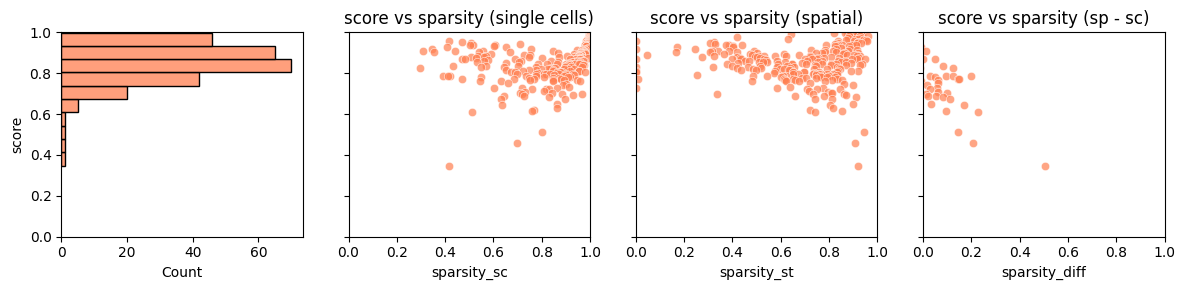

In [31]:
tgl.plot_training_scores(df)

<Figure size 640x480 with 0 Axes>

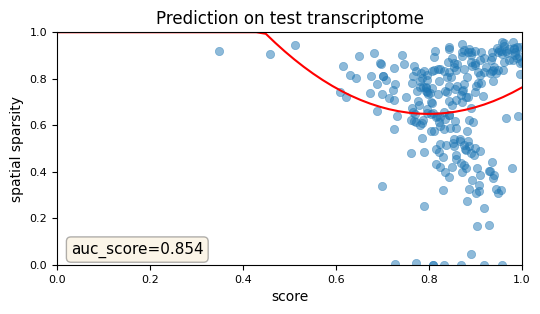

In [32]:
tgl.plot_auc_curve(df)

## Mapping Matrix
The mapping matrix is currently randomly initialized with entries $\sim \mathcal{N}(0,1)$.

To inital sparsity level can be analytically derived considering the **softmax** layer output distribution. i.e. a **Log-Normal on the simplex**.

The final sparsity can be numerically computed direcly from the mapping output.

The entropy regularizer, the $l_1$ regularizer and the filter additional terms might affect the final sparsity level. ICs direclty determine the initial one.

# Normalized Counts
We are now testing the model on non log-transformed data, that is, counts are only normalized to the total.

These datasets are not pre-processed completely, meaning that all SC obsevations are present (no cell selection or harmonization).

The model is trained on the shared genes set as usual.

In [15]:
del adata_sc, adata_st

In [4]:
adata_sc = sc.read_h5ad("H:/Il mio Drive/data_tangram/counts100k_norm_wo_raw_light.h5ad")  # float32
adata_sc

AnnData object with n_obs × n_vars = 100000 × 31053
    obs: 'nUMI', 'nGene', 'dataset', 'QC', 'cluster', 'Allen.cluster_id', 'Allen.cluster_label', 'Allen.cluster_color', 'Allen.class_label', 'Allen.subclass_label', 'comb.QC'
    var: 'gene_ids', 'feature_types'

In [5]:
adata_st = sc.read_h5ad("H:/Il mio Drive/dati_per_enrico.lnk/slice200_norm_wo_raw.h5ad")
adata_st

AnnData object with n_obs × n_vars = 2155 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'is_sequential', 'is_combinatorial'
    uns: 'spatialdata_attrs'

In [6]:
print(f"SC min: {adata_sc.X.min()}, max: {adata_sc.X.max()}")
print(f"ST min: {adata_st.X.min()}, max: {adata_st.X.max()}")

SC min: 0.0, max: 12.910377502441406
ST min: 0.0, max: 213.2812957763672


In [ ]:
# adata_sc.uns['hvg']  # flavour might require log1p

Despite the difference in range, both datasets are normalized but not log-transformed.

In [11]:
ad_map_nolog, mapper_nolog, data_nolog = tgl.map_cells_to_space(
    adata_sc=adata_sc, 
    adata_st=adata_st, 
    mode='vanilla',
    num_epochs=200,
    lambda_d=1e2,
    lambda_g1=1,
    lambda_g2=1,
    lambda_r=1e-6,
    lambda_l1=2e-9,
    lambda_l2=2e-9,
    random_state=42,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


in



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 215 M  | n/a  
---------------------------------------------------------
215 M     Trainable params
0         Non-trainable params
215 M     Total params
862.000   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
Trainig:   0%|                                                                                 | 0/200 [00:00<?, ?it/s]

Training with 252 genes
S matrix shape: torch.Size([100000, 252])
G matrix shape: torch.Size([2155, 252])


Trainig:   0%|▎                                                                      | 1/200 [00:34<1:55:57, 34.96s/it]

Epoch 0: {'Total loss': 0.7830399870872498, 'Score': 0.35379189252853394, 'KL divergence': 8.49762000143528e-06}


Trainig:  50%|██████████████████████████████████▊                                  | 101/200 [53:49<1:03:27, 38.46s/it]

Epoch 100: {'Total loss': -1.2688161134719849, 'Score': 0.826253354549408, 'KL divergence': 2.2063031792640686e-06}


Trainig: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [1:47:33<00:00, 32.27s/it]


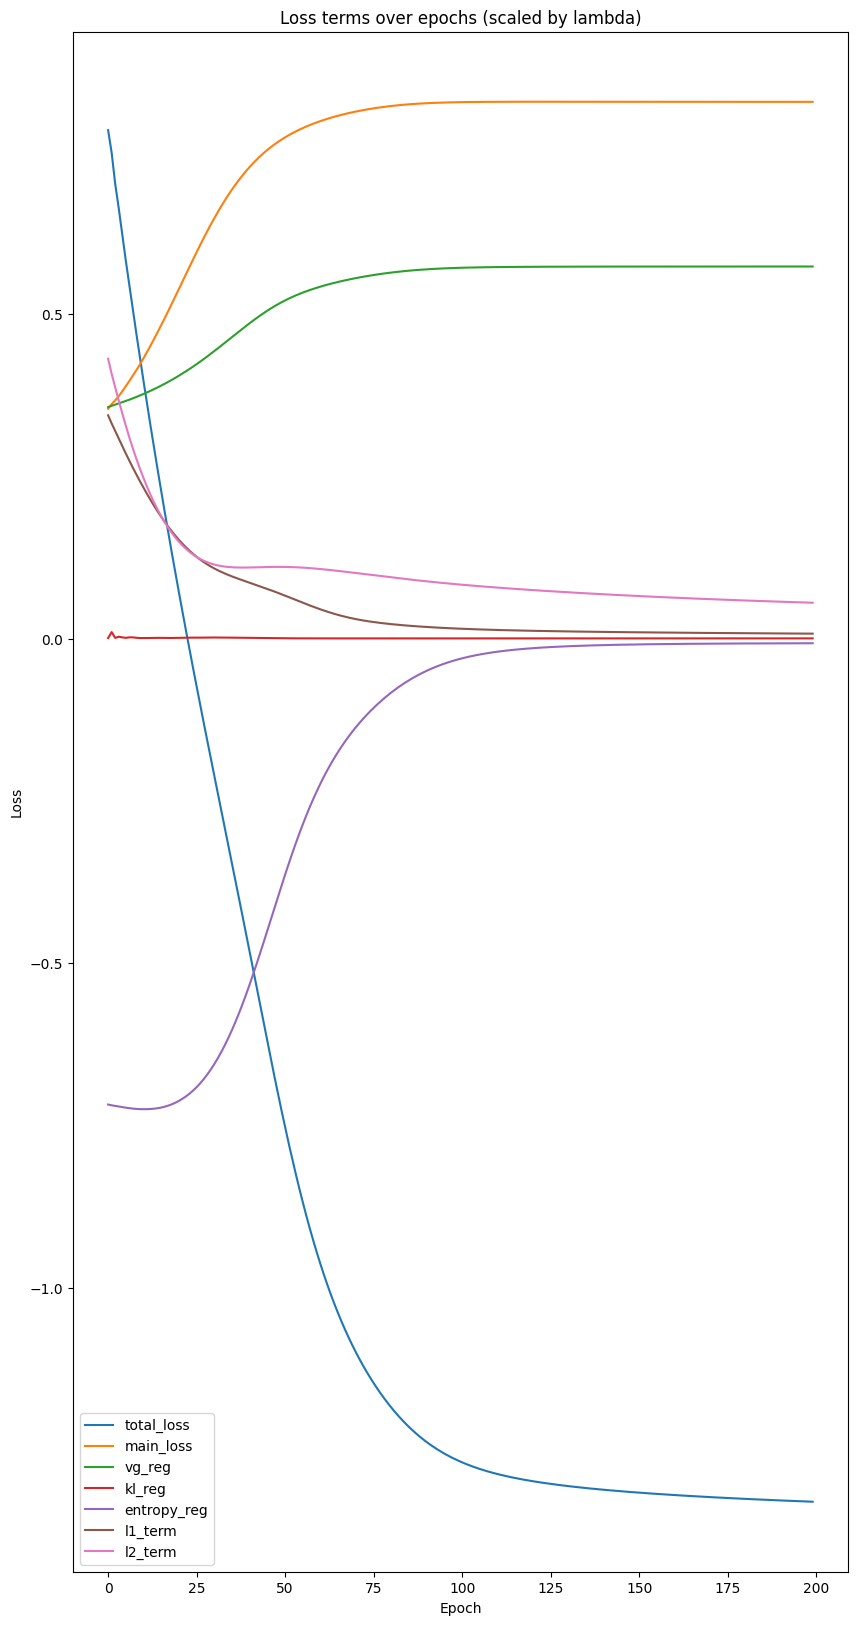

In [12]:
# Plot loss terms
tgl.plot_training_history(adata_map=ad_map_nolog, hyperpams=mapper_nolog.hparams, 
                         log_scale=False, lambda_scale=True)

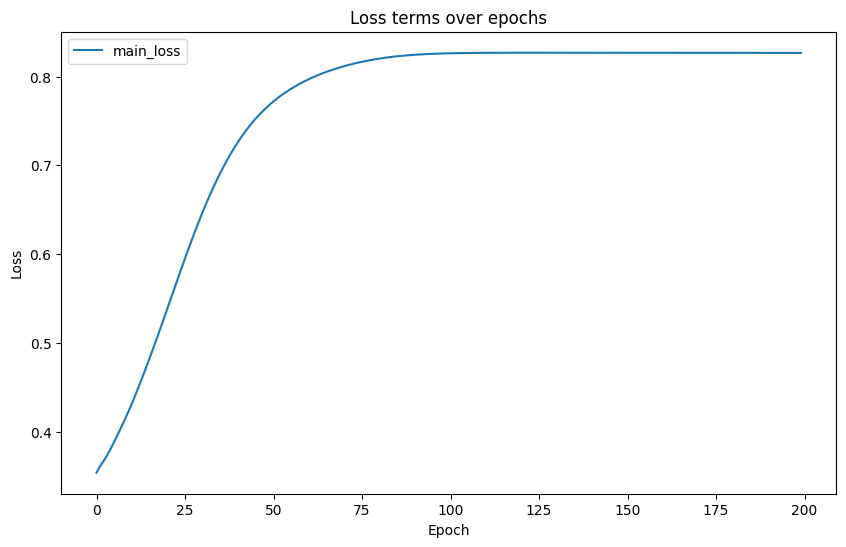

In [13]:
tgl.plot_loss_term(adata_map=ad_map_nolog, loss_key="main_loss", lambda_scale=False)

Despite the appearent data format mismatch, alignment is still close to optimal.

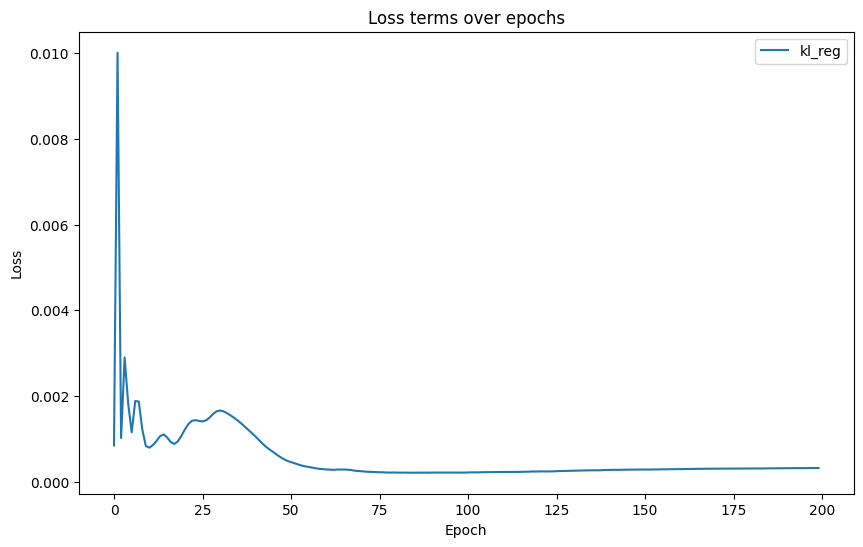

In [14]:
tgl.plot_loss_term(adata_map=ad_map_nolog, loss_key="kl_reg", lambda_scale=False)

# Early Stopping

In [9]:
ad_map_vanilla, mapper_vanilla, data_vanilla = tgl.map_cells_to_space(
        adata_sc, 
        adata_st, 
        mode='vanilla',
        learning_rate=0.1,
        num_epochs=1000,
        lambda_d=1e2,
        lambda_g1=1,
        lambda_g2=1,
        lambda_r=1e-6,
        lambda_l1=2e-9,
        lambda_l2=2e-9,
        random_state=42,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 164 M  | n/a  
---------------------------------------------------------
164 M     Trainable params
0         Non-trainable params
164 M     Total params
659.839   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])

Validation 0: {'Score': 0.5169236660003662, 'Sparsity-weighted score': 0.002567180199548602, 'AUC': 0.6502220630645752, 'Entropy': 0.9348827004432678}


Trainig:   0%|                                                                                | 0/1000 [00:00<?, ?it/s]


Training with 252 genes
S matrix shape: torch.Size([77337, 252])
G matrix shape: torch.Size([2133, 252])


Trainig:   0%|                                                                      | 1/1000 [00:25<7:04:58, 25.52s/it]Metric main_loss improved. New best score: 0.517


Epoch 0: {'loss': 0.11898645758628845, 'main_loss': 0.5169236660003662, 'vg_reg': 0.5126924514770508, 'kl_reg': 0.0011752592399716377, 'entropy_reg': -0.5542079210281372, 'l1_term': 0.2632603943347931, 'l2_term': 0.329958975315094}


Trainig:  10%|██████▌                                                              | 96/1000 [14:45<2:19:02,  9.23s/it]


In [16]:
print(mapper_vanilla.current_epoch)
print(mapper_vanilla.trainer.logged_metrics.keys())

96
dict_keys(['loss', 'main_loss', 'vg_reg', 'kl_reg', 'entropy_reg', 'l1_term', 'l2_term', 'lr'])


In [17]:
mapper_vanilla.trainer.logged_metrics['lr']

tensor(0.1000)

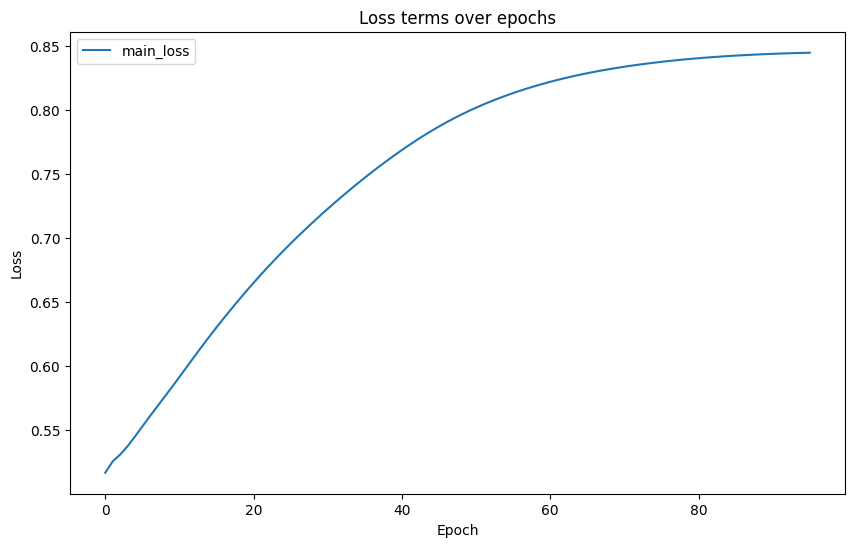

In [10]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map_vanilla, loss_key="main_loss", lambda_scale=False)

# Conclusions
The experiments on the baseline model allow to draw two main conlusions:
1. The main loss - KL term model achieves the best alignment score of all. This does not necessarely translate in the best mapping, as cell distributions might not be sparse enough, meaning that the matrix $M$ is optimizing the score, but fails to succesfully attribute cells to spots decisively.
2. Regularization terms are not of strict necessity and, if used, must be weighted carefully to avoid impairing the learning process completely.